# Setup

In [2]:
import sys
from IPython.display import display, HTML
import torch

In [3]:
# Check if GPU is enabled (for Colab users)
in_colab = "google.colab" in sys.modules
if in_colab:
  if torch.cuda.is_available():
      device_name = torch.cuda.get_device_name(0)
      print(f"✅ GPU detected: {device_name}")
  else:
      warning_html = """
      <div style="background-color:#fff3cd;border:1px solid #ffeeba;
                  padding:15px;border-radius:8px;">
          ⚠️ <b>No GPU detected.</b><br>
          To speed up model inference:
          <ol>
              <li>Click on <b>Runtime</b> (top menu)</li>
              <li>Select <b>Change runtime type</b></li>
              <li>Set <b>Hardware accelerator</b> to <b>GPU</b></li>
              <li>Then re-run this notebook.</li>
          </ol>

          Or, you can continue to the next cells but it will take a while running on CPU... up to you!
      </div>
      """
      display(HTML(warning_html))
      device = torch.device("cpu")
      raise RuntimeError(
          "⚠️ No GPU detected. Please change: Runtime > Change runtime type > GPU."
      )

✅ GPU detected: Tesla T4


In [4]:
if in_colab:
    # Clone GitHub repo and move into it
    !git clone https://github.com/championjeyson/agb-prediction.git
    %cd agb-prediction

    # Install dependencies
    !pip install -r requirements.txt

    # # Make sure src/ is importable
    # sys.path.append("src")

else:
    # Make sure src/ is importable
    sys.path.append("..")
    # sys.path.append("../src")

fatal: destination path 'agb-prediction' already exists and is not an empty directory.
/content/agb-prediction


In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import xarray as xr

from src.utils.config import *
from src.imagery_processing import (
    process_s2_data,
    process_alos_data,
    process_dem_data,
)
from src.models import (
    load_model_config,
    load_model_data_statistics,
)

In [6]:
# Load common config
CFG = get_config("default.yaml")
CHUNKSIZE = get_chunk_size(CFG)

# Visualize some of the inputs
Note that this will only be possible for small emough imagery. Although computation is done for small chucks, the plotting is done for the full images, which might be limited depending on the resources available.

## Parameters

In [7]:
longer_dim_figsize = 8

## Sentinel-2 Imagery

/usr/local/lib/python3.12/dist-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


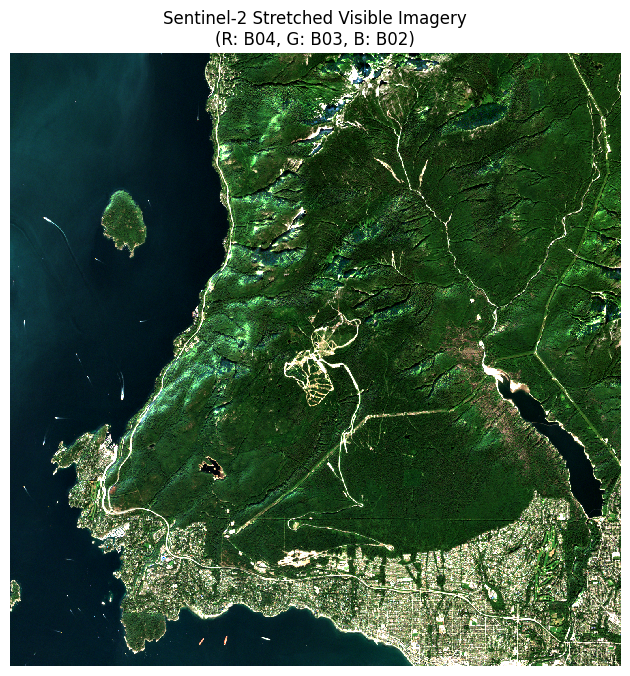

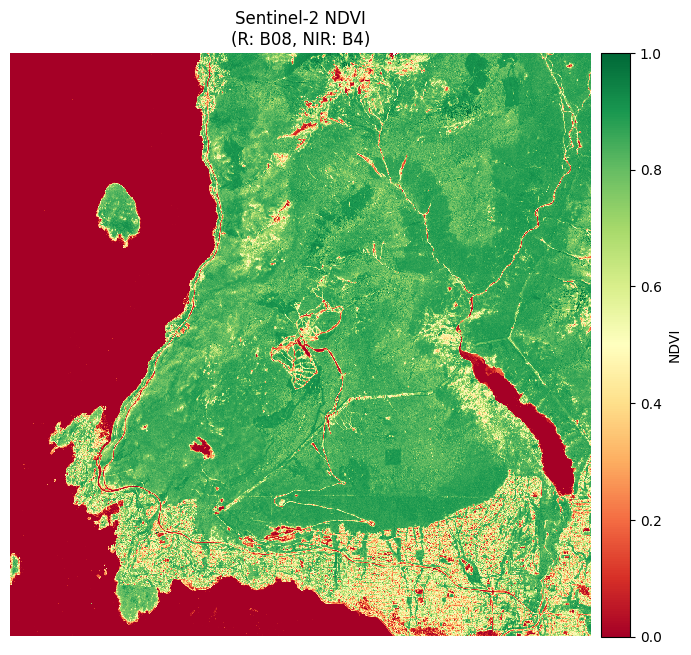

In [8]:
# # Load config
# CFG = get_config("default.yaml")

# # Load model config and data statistics
# model_cfg = load_model_config()
# model_norm_values = load_model_data_statistics()

# Process Sentinel-2 data
dict_s2_processed_bands, _, xds_s2_ref_band, *_ = process_s2_data()

# Extract and display visible imagery (stretched)
s2_rgb = xr.concat([dict_s2_processed_bands['B04'], dict_s2_processed_bands['B03'], dict_s2_processed_bands['B02']], dim='band').transpose("y", "x", "band")
p2, p98 = np.percentile(s2_rgb, (2, 98))
s2_rgb_stretch = np.clip((s2_rgb - p2) / (p98 - p2), 0, 1)

figsize = (np.array(s2_rgb.shape[:2]))/max(s2_rgb.shape[:2]) * longer_dim_figsize

fig, ax = plt.subplots(figsize=figsize)
im = ax.imshow(s2_rgb_stretch, interpolation='none')
ax.set_title("Sentinel-2 Stretched Visible Imagery\n(R: B04, G: B03, B: B02)")
ax.axis("off")

# Extract and display NDVI image
nir = dict_s2_processed_bands["B08"]
red = dict_s2_processed_bands["B04"]
s2_ndvi = (nir - red) / (nir + red)

fig, ax = plt.subplots(figsize=figsize)
im = ax.imshow(s2_ndvi, cmap="RdYlGn", vmin=0, vmax=1, interpolation='none')
ax.set_title("Sentinel-2 NDVI\n(R: B08, NIR: B4)")
ax.axis("off")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cb = fig.colorbar(im, cax=cax)
cb.set_label("NDVI")

plt.show()

## ALOS/PALSAR Imagery

(np.float64(-0.5), np.float64(1506.5), np.float64(1513.5), np.float64(-0.5))

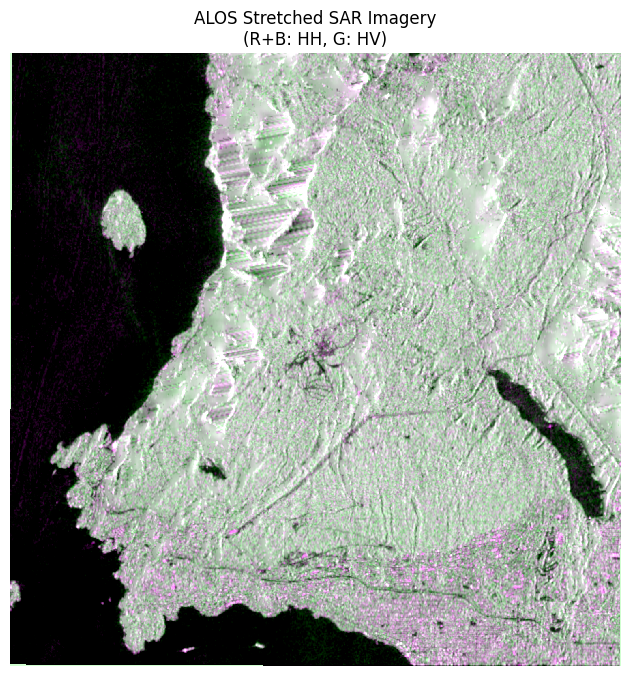

In [9]:
# Process ALOS data
xds_alos_gamma = process_alos_data(xds_s2_ref_band)

# Extract and display SAR imagery (stretched)
bands = ['HH', 'HV', 'HH']
da_list = [ xds_alos_gamma.sel(band=b) for b in bands ]
stretched_list = []
for da in da_list:
    plow = np.nanpercentile(da, 20)
    p98 = np.nanpercentile(da, 98)
    stretched = (da - plow) / (p98 - plow)
    stretched = stretched.clip(0, 1)
    stretched_list.append(stretched)
xds_alos_gamma_rgb_stretch = xr.concat(stretched_list, dim='band').transpose("y", "x", "band")

figsize = (np.array(xds_alos_gamma_rgb_stretch.shape[:2]))/max(xds_alos_gamma_rgb_stretch.shape[:2]) * longer_dim_figsize

fig, ax = plt.subplots(figsize=figsize)
im = ax.imshow(xds_alos_gamma_rgb_stretch, interpolation='none')
ax.set_title("ALOS Stretched SAR Imagery\n(R+B: HH, G: HV)")
ax.axis("off")

## Digital Elevation Model (DEM)

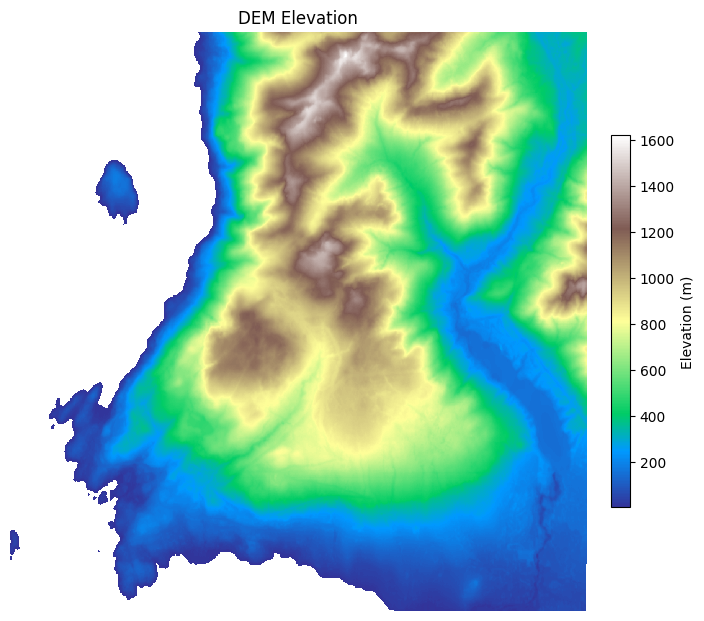

In [10]:
# Process DEM data
xds_dem = process_dem_data(xds_s2_ref_band)
xds_dem = xds_dem.where(xds_dem > 0, np.nan)

# Create figure
fig, ax = plt.subplots(figsize=figsize)
im = ax.imshow(xds_dem, cmap='terrain', interpolation='none')
ax.set_title("DEM Elevation")
ax.axis("off")

# Add colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label("Elevation (m)")

plt.show()

## Normalized bands as input for the model

# Run inference
If using the example provided, and the GPU under the free plan of Google Colab, it should take about 5 minutes to run.

In [26]:
from src.inference import run_inference
run_inference()

/content/agb-prediction/src/imagery_processing/__init__.py:114: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  xds_lc_encoded = xr.apply_ufunc(


Unfreeze last layer (mean regressor)... args.freeze_last_mean=False


Predicting patches: 100%|██████████| 100/100 [06:15<00:00,  3.75s/patch]


0

# Visualize output

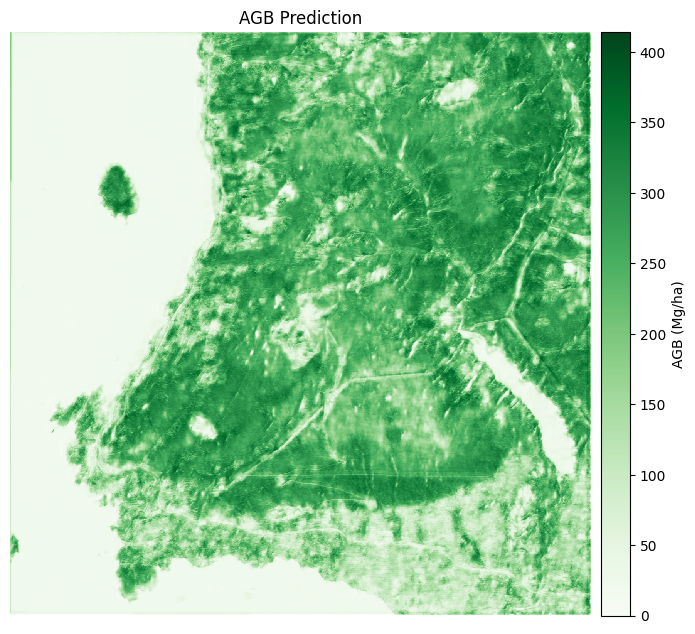

In [13]:
import rioxarray
from pathlib import Path

# Load image
agb_prediction_path = Path('./output/agb_prediction.tif')
agb_prediction_path = Path('./output/test_output_alos_pct_s2_dem_min_max.tif')
agb_prediction_path = Path('./output/test_output_pct_but_dem_min_max.tif')
xds_agb = rioxarray.open_rasterio(
    agb_prediction_path,
    masked=True,
    chunks=(1, CHUNKSIZE, CHUNKSIZE)
).squeeze()

# Plot image

fig, ax = plt.subplots(figsize=figsize)
im = ax.imshow(xds_agb, cmap="Greens", vmin=0, interpolation='none')
ax.set_title("AGB Prediction")
ax.axis("off")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cb = fig.colorbar(im, cax=cax)
cb.set_label("AGB (Mg/ha)")

plt.show()